In [1]:
import monai
import matplotlib.pyplot as plt
import numpy as np

import os
from glob import glob
from datetime import datetime
import torch
from monai.metrics import PSNRMetric
from monai.networks.nets import AutoEncoder
from monai.config import print_config
from monai.data import Dataset, DataLoader, partition_dataset
from monai.utils import set_determinism, first
from monai.transforms import (
    Compose,
    LoadImage,
    ScaleIntensityd,
    Lambda,
    SpatialPadd,
)


In [2]:
root_dir = "/data/LargeArchiveStorage/MedicalSegmentDecathlon"

all_images = sorted(glob(f"{root_dir}/Task01_BrainTumour/images*/*.nii*"))
train_images, eval_images = partition_dataset(all_images, (4, 1), shuffle=True,seed=42)

device = "cuda:0" 
IN_KEY = "in_images"
OUT_KEY = "ge_image"
keys = (IN_KEY, OUT_KEY)
pad_size = (256, 256, 160)

def _rearrange_images(img):
    img = img.permute(3, 0, 1, 2)
    return {IN_KEY: img[:3], OUT_KEY: img[3:]}


val_transforms = Compose([
    LoadImage(),
    Lambda(_rearrange_images),
    ScaleIntensityd(keys,channel_wise=True),
    SpatialPadd(keys, spatial_size=pad_size)
])

val_ds = Dataset(eval_images, val_transforms)
val_dl = DataLoader(val_ds, num_workers=0, batch_size=4, shuffle=False)

In [3]:
batch=first(val_dl)

In [4]:
model = AutoEncoder(
    spatial_dims=3,
    in_channels=3,
    out_channels=1,
    num_res_units=2,
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2, 2),
).to(device)

model.load_state_dict(torch.load("/home/localek10/cme01_home/ge_autoencoder1.pt"))

<All keys matched successfully>

In [5]:
inputs, outputs_gt = batch[IN_KEY].to(device), batch[OUT_KEY].to(device)
model.eval()
outputs = model(inputs)

Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1712608885084/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)


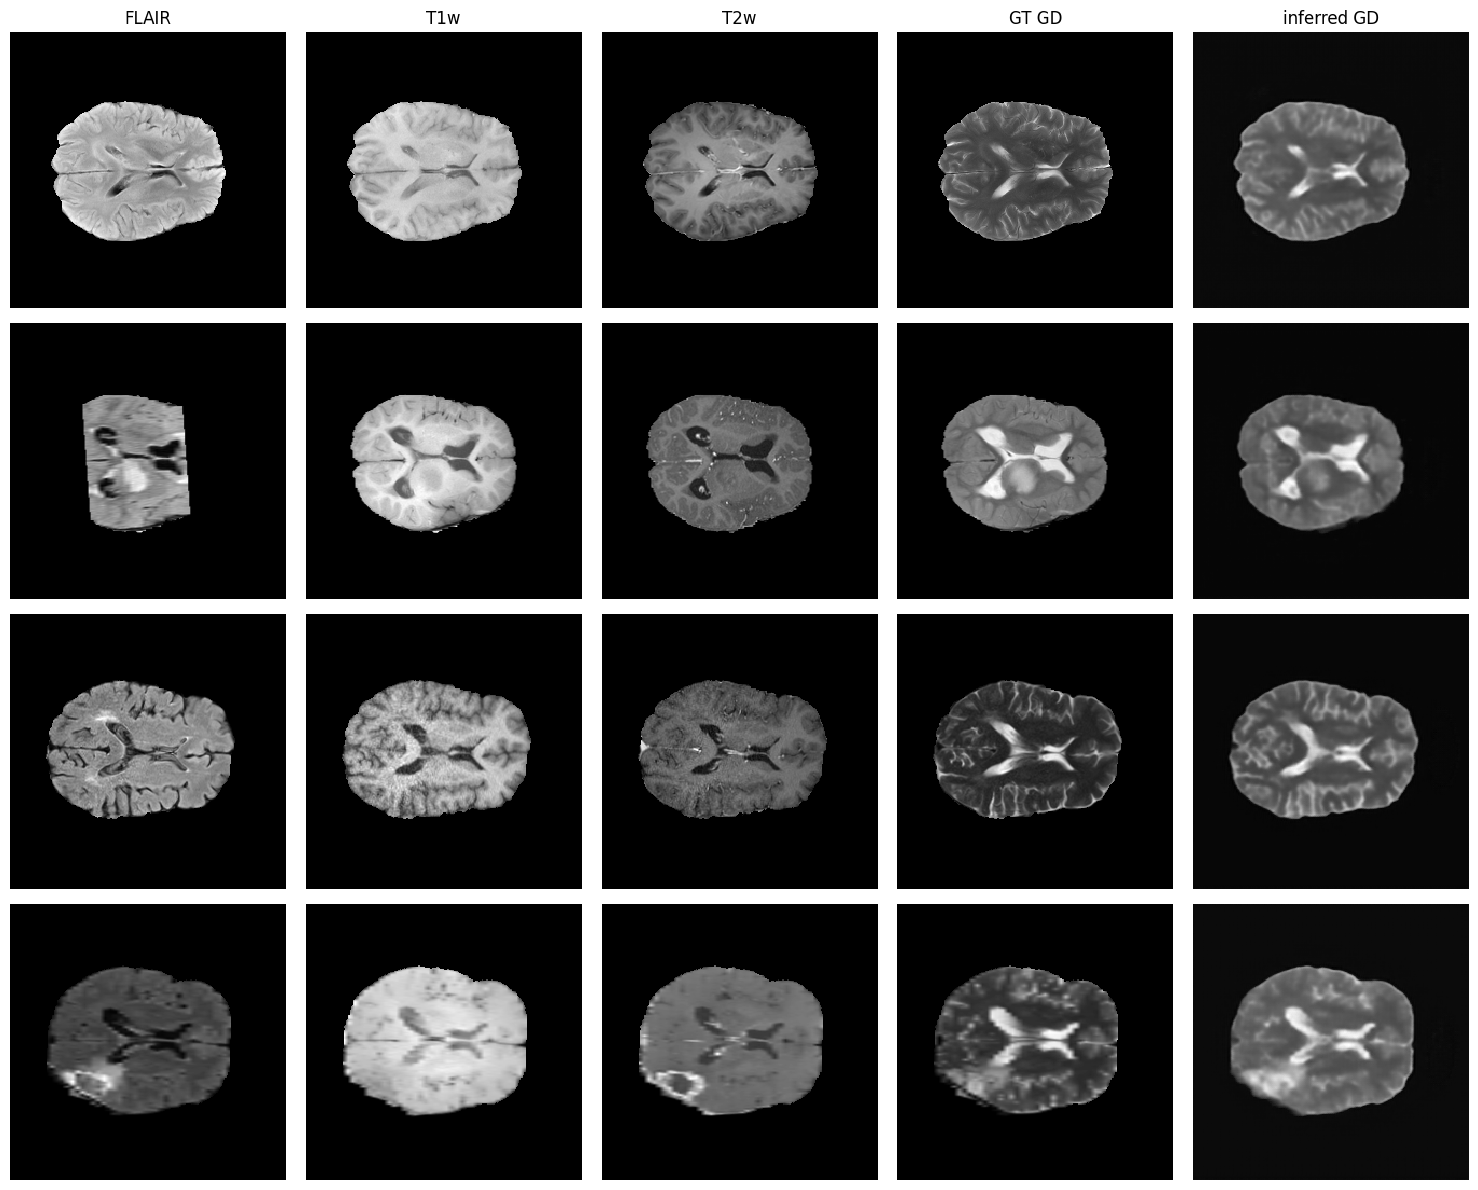

In [7]:
def imshows(ims,slices):
    """Visualises a list of dictionaries.

    Each key of the dictionary will be used as a column, and
    each element of the list will be a row.
    """
    nrow = len(ims)
    ncol = len(ims[0])
    fig, axes = plt.subplots(nrow, ncol, figsize=(
        ncol * 3, nrow * 3), facecolor='white',layout="tight")
    
    for i, im_dict in enumerate(ims):
        for j, (title, im) in enumerate(im_dict.items()):
            im = im[slices].detach().cpu().numpy()
            ax = axes[j] if nrow == 1 else axes[i, j]
            if i==0:ax.set_title(f"{title}")
            im_show = ax.imshow(im,interpolation="none",cmap="gray")
            ax.axis("off")

to_imshow = []
slice_idx=80
    
for idx in range(outputs.shape[0]):
    to_imshow.append(
        {
            "FLAIR": inputs[idx,0],
            "T1w": inputs[idx,1],
            "T2w": inputs[idx,2],
            "GT GD": outputs_gt[idx,0],
            "inferred GD": outputs[idx,0],
        }
    )
imshows(to_imshow,(slice(None),slice(None),slice_idx))